# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=',', index_col=0)
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=',', index_col=0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [4]:
pd.isna(azdias).sum().sort_values(ascending=False)[:10]

ALTER_KIND4                    37394
ALTER_KIND3                    37183
ALTER_KIND2                    36270
ALTER_KIND1                    34051
EXTSEL992                      27136
KK_KUNDENTYP                   24541
ALTERSKATEGORIE_FEIN           10801
D19_VERSAND_ONLINE_QUOTE_12    10571
D19_BANKEN_ONLINE_QUOTE_12     10571
D19_VERSI_ONLINE_QUOTE_12      10571
dtype: int64

In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0.0,1.0,4.0
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3.0,FOOD,SINGLE_BUYER,0.0,1.0,4.0
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0.0,2.0,4.0
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1.0,COSMETIC,MULTI_BUYER,0.0,1.0,4.0
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1.0,FOOD,MULTI_BUYER,0.0,1.0,3.0


In [6]:
pd.isna(customers).sum().sort_values(ascending=False)[:10]

ALTER_KIND4     39493
ALTER_KIND3     39255
ALTER_KIND2     38438
ALTER_KIND1     36994
KK_KUNDENTYP    23072
EXTSEL992       17676
KBA05_MAXAH     11471
KBA05_SEG8      11471
KBA05_KW2       11471
KBA05_KW1       11471
dtype: int64

In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37436 entries, 0 to 37435
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(289), int64(71), object(6)
memory usage: 104.8+ MB


In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39545 entries, 0 to 39544
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(276), int64(85), object(8)
memory usage: 111.6+ MB


## Data Preprocessing - Handling missing values

We notice there are mismatches in Azdias and Customers file. We need to first align the features of these two datasets.

In [9]:
mismatch_col = set(customers.columns) - set(azdias.columns)
mismatch_col

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [10]:
customers.drop(mismatch_col, axis=1, inplace = True)
customers.shape

(39545, 366)

Read in attributes files

In [11]:
! pip install openpyxl

In [12]:
import openpyxl

info_levels = pd.read_excel(
    './DIAS Information Levels - Attributes 2017.xlsx',
    engine='openpyxl',
    index_col = 0,
    header=1
)
info_levels.index = np.arange(len(info_levels))

attributes = pd.read_excel(
    './DIAS Attributes - Values 2017.xlsx',
    engine='openpyxl',
    index_col = 0,
    header = 1
)
attributes.index = np.arange(len(attributes))

In [13]:
info_levels.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [14]:
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [15]:
print('There are {} attributes in Azdias file not explained by the Attribute file'.format(len(set(azdias.columns.unique()) - set(attributes['Attribute'].unique()))))
print('There are {} attributes in Customers file not explained by the Attribute file'.format(len(set(customers.columns.unique()) - set(attributes['Attribute'].unique()))))

There are 94 attributes in Azdias file not explained by the Attribute file
There are 94 attributes in Customers file not explained by the Attribute file


In [16]:
attributes 

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
...,...,...,...,...
2253,NaN,NaN,2,smart
2254,NaN,NaN,3,fair supplied
2255,NaN,NaN,4,price driven
2256,NaN,NaN,5,seeking orientation


Check if there is any invalid attributes in Attribute file. <br>

In [17]:
attributes['Attribute'] = attributes['Attribute'].ffill()
attributes['Attribute'].value_counts()

CAMEO_DEU_2015           44
LP_LEBENSPHASE_FEIN      40
CAMEO_DEUINTL_2015       26
ALTER_HH                 22
PRAEGENDE_JUGENDJAHRE    16
                         ..
GEBURTSJAHR               1
MIN_GEBAEUDEJAHR          1
ANZ_TITEL                 1
ANZ_PERSONEN              1
ANZ_HAUSHALTE_AKTIV       1
Name: Attribute, Length: 314, dtype: int64

We notice there are few attributes with only 1 value. Let's take a look into that.

In [18]:
attribute_col = attributes['Attribute'].value_counts()[attributes['Attribute'].value_counts() == 1].index
attributes.loc[attributes['Attribute'].isin(attribute_col)]

,Attribute,Description,Value,Meaning
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
37,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
38,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
39,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
711,GEBURTSJAHR,year of birth,…,numeric value
1167,KBA13_ANZAHL_PKW,number of cars in the PLZ8,…,numeric value
1986,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...,…,numeric value


It seems fine. Next step, we need to explore the 'unkown' and 'no classification possible' values.

In [19]:
unkown_attribute = attributes[attributes['Meaning'].str.contains("unknown|no ").astype(bool)]
unkown_attribute.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
49,BIP_FLAG,NaN,0,no company in the building
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown


In [20]:
unknown_values = unkown_attribute[['Attribute', 'Value']]
unknown_values.loc[:, 'Value'] = unknown_values.loc[:, 'Value'].astype(str)
unknown_values = unknown_values.groupby('Attribute')['Value'].apply(', '.join).reset_index()
unknown_values.loc[:, 'Value'] = unknown_values.loc[:, 'Value'].str.split(', ')
unknown_values.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Attribute,Value
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


In [21]:
# convert the unknown values in azdias to NaNs
for att in unknown_values['Attribute']:
    if att in azdias.columns:
        azdias_unknown = azdias.loc[:, att].isin(unknown_values.loc[unknown_values['Attribute']==att, 'Value'].iloc[0])
        azdias.loc[azdias_unknown, att] = np.nan
    else:
        continue
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [22]:
# convert the unknown values in customers to NaNs
for att in unknown_values['Attribute']:
    if att in customers.columns:
        azdias_unknown = customers.loc[:, att].isin(unknown_values.loc[unknown_values['Attribute']==att, 'Value'].iloc[0])
        customers.loc[azdias_unknown, att] = np.nan
    else:
        continue
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3.0,1.0,4.0
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,NaN,9.0,NaN,3.0,1.0,4.0
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3.0,2.0,4.0
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1.0,1.0,4.0
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1.0,1.0,3.0


We noticed there are many columns with NaN, we need to explore the missing values for both datasets. <br>
Below are the attributes that have over 30% of NaN values

41 41


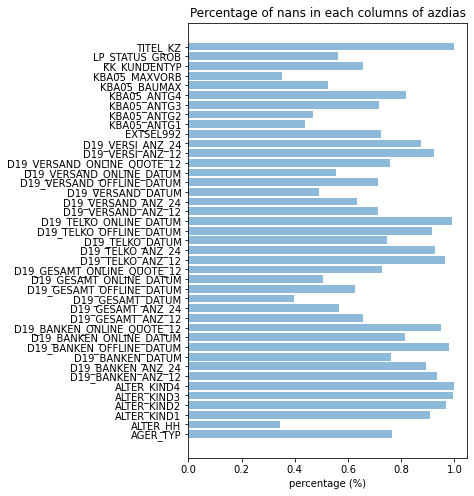

In [23]:
cols = azdias.columns
azdias_na = pd.isna(azdias).sum() / len(azdias)
col_names_azdias = azdias_na[azdias_na > 0.3].index
data = [i for i in azdias_na if i >=0.3]
y_pos = np.arange(len(col_names_azdias))
print(len(data), len(y_pos))
f, ax = plt.subplots(figsize=(5,8))
plt.barh(y_pos, data, align='center', alpha=0.5)
plt.yticks(y_pos, col_names_azdias)
plt.xlabel('percentage (%)')
plt.title('Percentage of nans in each columns of azdias')
plt.show()

Drop the colums with missing values over 30%

In [24]:
azdias.drop(col_names_azdias, axis=1, inplace = True)

We then need to look into the missing values for every row in both datasets. 

Text(0.5, 1.0, 'Distribution of missing values per row in Azdias Data')

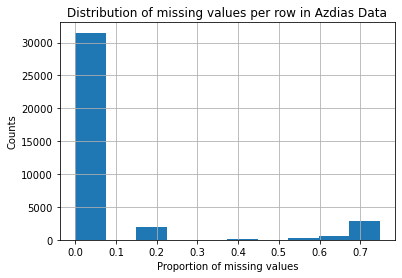

In [25]:
# find proportion of missing value in each row

missing_row_azdias = pd.isna(azdias).sum(axis=1) / azdias.shape[1]
missing_row_azdias.hist()
plt.xlabel('Proportion of missing values')
plt.ylabel('Counts')
plt.title('Distribution of missing values per row in Azdias Data')

According to the above figures, the proportion of the missing values in the majority of rows is below 30%. Therefore, we can remove rows containing over 30% empty values. 

In [26]:
azdias.drop(missing_row_azdias[missing_row_azdias > 0.3].index, axis=0, inplace=True)

In [27]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33461 entries, 1 to 37434
Columns: 325 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(279), int64(40), object(6)
memory usage: 83.2+ MB


## Transform Data Type

From above information, there are 6 object data types, we need to transform the object to correct data type

In [28]:
obj_colname = []
for col in azdias.columns:
    if 'object' in str(azdias[col].dtype):
        print(col)
        obj_colname.append(col)

CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015
D19_LETZTER_KAUF_BRANCHE
EINGEFUEGT_AM
OST_WEST_KZ


In [29]:
azdias[obj_colname]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
37428,1D,1,15,D19_SAMMELARTIKEL,1992-02-10 00:00:00,W
37429,2B,2,13,NaN,1996-01-24 00:00:00,O
37430,2D,2,14,D19_BEKLEIDUNG_REST,1993-08-25 00:00:00,O
37431,1D,1,15,D19_UNBEKANNT,1996-06-27 00:00:00,O


In [30]:
azdias['CAMEO_DEUG_2015'].value_counts()

8.0    3089
8      2611
9.0    2611
6.0    2465
4.0    2421
9      2057
6      2044
4      1938
3.0    1928
2.0    1844
7.0    1805
3      1615
2      1542
7      1507
5.0    1259
5      1005
1.0     865
1       697
X        10
Name: CAMEO_DEUG_2015, dtype: int64

In [31]:
# change X to NaN
azdias['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)

In [32]:
azdias['CAMEO_INTL_2015'].value_counts()

51.0    3137
51      2572
24.0    2142
41.0    2119
41      1747
24      1747
14.0    1421
43.0    1339
14      1161
43      1094
54.0    1062
54       893
25.0     892
22.0     756
25       698
45.0     607
22       603
55.0     582
13.0     566
23.0     559
13       516
23       505
45       504
52.0     502
55       469
31.0     431
15.0     419
52       408
34.0     395
31       362
34       339
44.0     335
44       305
12.0     303
15       299
12       263
35.0     251
32.0     244
33.0     225
32       184
35       182
33       165
XX        10
Name: CAMEO_INTL_2015, dtype: int64

In [33]:
# change XX to np.nan
azdias['CAMEO_INTL_2015'].replace('XX', np.nan, inplace=True)

In [34]:
azdias[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].astype(float)

In [35]:
azdias['OST_WEST_KZ'].value_counts()

W    26654
O     6807
Name: OST_WEST_KZ, dtype: int64

In [36]:
attributes.loc[attributes['Attribute'] == 'OST_WEST_KZ']

,Attribute,Description,Value,Meaning
2013,OST_WEST_KZ,flag indicating the former GDR/FRG,-1,unknown
2014,OST_WEST_KZ,NaN,O,East (GDR)
2015,OST_WEST_KZ,NaN,W,West (FRG)


In [37]:
# encode OST_WEST_KZ to 0 (O) and 1 (W)
azdias['OST_WEST_KZ'].replace({'W': 1, 'O': 0}, inplace=True)

In [38]:
attributes.loc[attributes['Attribute'] == 'EINGEFUEGT_AM']

,Attribute,Description,Value,Meaning


In [39]:
attributes.loc[attributes['Attribute'] == 'D19_LETZTER_KAUF_BRANCHE']

,Attribute,Description,Value,Meaning


In [40]:
attributes.loc[attributes['Attribute'] == 'CAMEO_DEU_2015']

,Attribute,Description,Value,Meaning
61,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1A,Work-Life-Balance
62,CAMEO_DEU_2015,NaN,1B,Wealthy Best Ager
63,CAMEO_DEU_2015,NaN,1C,Successful Songwriter
64,CAMEO_DEU_2015,NaN,1D,Old Nobility
65,CAMEO_DEU_2015,NaN,1E,City Nobility
66,CAMEO_DEU_2015,NaN,2A,Cottage Chic
67,CAMEO_DEU_2015,NaN,2B,Noble Jogger
68,CAMEO_DEU_2015,NaN,2C,Established gourmet
69,CAMEO_DEU_2015,NaN,2D,Fine Management
70,CAMEO_DEU_2015,NaN,3A,Career & Family


In [41]:
azdias['CAMEO_DEU_2015'].value_counts()

6B    2433
8A    2232
4C    1999
3C    1497
7A    1440
2D    1428
8B    1390
4A    1359
3D    1349
8C    1308
9D    1261
9B    1141
9C    1075
7B    1036
9A     910
2C     793
8D     770
6E     686
6C     640
5D     608
2B     599
2A     566
5A     518
1D     514
1A     483
5B     428
7C     416
3A     401
4D     393
5C     390
4B     367
3B     296
9E     281
6A     275
4E     241
6D     239
6F     236
7D     231
1E     204
5F     194
1C     191
7E     189
1B     170
5E     126
XX      10
Name: CAMEO_DEU_2015, dtype: int64

In [42]:
# encode CAMEO_DEU_2015 
azdias['CAMEO_DEU_2015'].replace('XX', np.nan, inplace=True)
deu_values = attributes.loc[attributes['Attribute'] == 'CAMEO_DEU_2015', 'Value']
deu_values.index = np.arange(len(deu_values))
deu_dict = deu_values.to_dict()
deu_dict = dict(zip(deu_dict.values(), deu_dict.keys()))
azdias.replace({'CAMEO_DEU_2015': deu_dict}, inplace=True)
azdias['CAMEO_DEU_2015'].value_counts()

25.0    2433
35.0    2232
15.0    1999
11.0    1497
30.0    1440
8.0     1428
36.0    1390
13.0    1359
12.0    1349
37.0    1308
42.0    1261
40.0    1141
41.0    1075
31.0    1036
39.0     910
7.0      793
38.0     770
28.0     686
26.0     640
21.0     608
6.0      599
5.0      566
18.0     518
3.0      514
0.0      483
19.0     428
32.0     416
9.0      401
16.0     393
20.0     390
14.0     367
10.0     296
43.0     281
24.0     275
17.0     241
27.0     239
29.0     236
33.0     231
4.0      204
23.0     194
2.0      191
34.0     189
1.0      170
22.0     126
Name: CAMEO_DEU_2015, dtype: int64

Since we cannot find meaning for 'EINGEFUEGT_AM' and 'D19_LETZTER_KAUF_BRANCHE' in Attribute file, we will remove these two columns 

In [43]:
azdias.drop(['EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE'], axis=1, inplace=True)

### Apply the similar procedure to Customer file

In [44]:
customers.drop(col_names_azdias, axis=1, inplace = True)
customers.drop(missing_row_azdias[missing_row_azdias > 0.3].index, axis=0, inplace=True)
customers['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
customers['CAMEO_INTL_2015'].replace('XX', np.nan, inplace=True)
customers[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].astype(float)
customers['OST_WEST_KZ'].replace({'W': 1, 'O': 0}, inplace=True)

# encode CAMEO_DEU_2015 
customers['CAMEO_DEU_2015'].replace('XX', np.nan, inplace=True)
customers.replace({'CAMEO_DEU_2015': deu_dict}, inplace=True)

customers.drop(['EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE'], axis=1, inplace=True)

In [45]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33461 entries, 1 to 37434
Columns: 323 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(282), int64(41)
memory usage: 82.7 MB


In [46]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35570 entries, 1 to 39544
Columns: 323 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(282), int64(41)
memory usage: 87.9 MB


## Imputing and scaling

In [47]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()

azdias_col = azdias.columns
azdias = imputer.fit_transform(azdias)
azdias = pd.DataFrame(azdias, columns=azdias_col)

customers_col = customers.columns
customers = imputer.fit_transform(customers)
customers = pd.DataFrame(customers, columns=customers_col)

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

azdias = scaler.fit_transform(azdias)
azdias = pd.DataFrame(azdias, columns=azdias_col)

customers = scaler.fit_transform(customers)
customers = pd.DataFrame(customers, columns=customers_col)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### PCA

(0.0, 100.0)

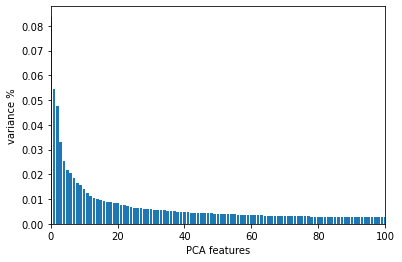

In [49]:
from sklearn.decomposition import PCA

pca_fit = PCA().fit(azdias)
pca_transform = pca_fit.transform(azdias)

features = np.arange(pca_fit.n_components_)
plt.bar(features, pca_fit.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xlim(left = 0, right = 100)

Text(0, 0.5, 'cumulative variance explained')

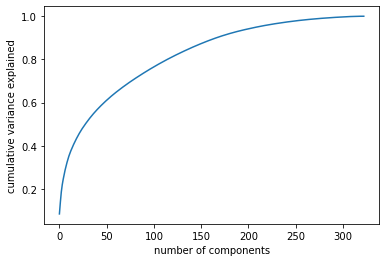

In [50]:
explained_var = pca_fit.explained_variance_ratio_
plt.plot(np.cumsum(explained_var))
plt.xlabel('number of components')
plt.ylabel('cumulative variance explained')

In [51]:
len(explained_var.cumsum()) - (explained_var.cumsum() > 0.90).sum()

166

If we have 277 components, then the explained variance will exceed 99%

Text(0, 0.5, 'cumulative variance explained')

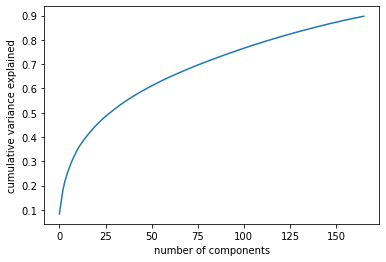

In [52]:
n = 166
azdias_pca_fit = PCA(n).fit(azdias)
azdias_pca_transform = azdias_pca_fit.transform(azdias)

plt.plot(np.cumsum(azdias_pca_fit.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative variance explained')

### Clustering

In [53]:
customers_pca_transform = azdias_pca_fit.transform(customers)

In [54]:
from sklearn.cluster import KMeans

scores = []
for i in range(1, 21):
    kmeans = KMeans(i)
    model = kmeans.fit(azdias_pca_transform)
    score = model.inertia_
    scores.append(score)

Text(0, 0.5, 'Distances')

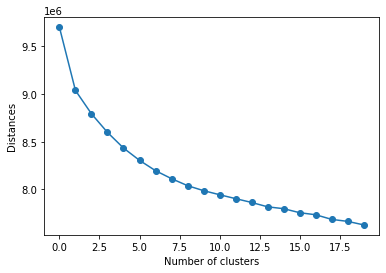

In [55]:
plt.plot(np.arange(20), scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distances')

In [56]:
azdias_kmeans = KMeans(8)
azdias_model = azdias_kmeans.fit(azdias_pca_transform)
azdias_predicted = azdias_model.predict(azdias_pca_transform)

azdias_cluster = pd.Series(azdias_predicted)
azdias_cluster = azdias_cluster.value_counts().sort_index()
azdias_cluster_percentage = azdias_cluster / azdias_cluster.sum()

customers_model = azdias_kmeans.fit(customers_pca_transform)
customers_predicted = customers_model.predict(customers_pca_transform)

customers_cluster = pd.Series(customers_predicted)
customers_cluster = customers_cluster.value_counts().sort_index()
customers_cluster_percentage = customers_cluster / customers_cluster.sum()

df = pd.DataFrame()
df['cluster'] = azdias_cluster_percentage
df['group'] = 'general_population'

df1 = pd.DataFrame()
df1['cluster'] = customers_cluster_percentage
df1['group'] = 'customers'

df_final = pd.concat([df, df1])

In [57]:
df_final = df_final.groupby('group')['cluster'].value_counts(normalize=True).mul(100)
df_final = df_final.rename('percent').reset_index()

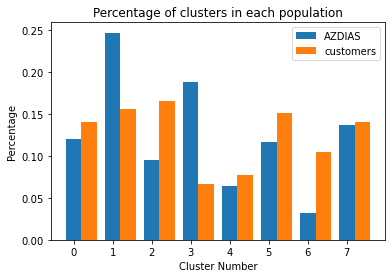

In [60]:
bar1 = azdias_cluster_percentage.index
bar2 = customers_cluster_percentage.index
w = 0.4
plt.bar(bar2, height = customers_cluster_percentage, width = w, label='AZDIAS')
plt.bar(bar1 + w, height = azdias_cluster_percentage, width = w, label = 'customers')

plt.xlabel("Cluster Number")
plt.ylabel("Percentage")
plt.title("Percentage of clusters in each population")
plt.legend()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [104]:
mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv', sep=',', index_col=0)

In [85]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3.0,0.0,2.0,4.0
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1.0,0.0,2.0,3.0
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3.0,0.0,1.0,4.0
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3.0,0.0,2.0,4.0
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3.0,0.0,1.0,3.0


In [86]:
mailout_train['RESPONSE']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
27506    0.0
27507    0.0
27508    0.0
27509    0.0
27510    NaN
Name: RESPONSE, Length: 27511, dtype: float64

Text(0.5, 1.0, 'Responses from Mailout')

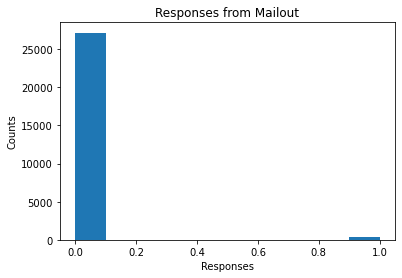

In [87]:
plt.hist(mailout_train['RESPONSE'])
plt.xlabel('Responses')
plt.ylabel('Counts')
plt.title('Responses from Mailout')

The data from Mailout-train is highly imbalanced

We need to clean data for mailout-train and mailout-test

In [88]:
def convert_nan(df, unknown_values):
    for att in unknown_values['Attribute']:
        if att in df.columns:
            azdias_unknown = df.loc[:, att].isin(unknown_values.loc[unknown_values['Attribute']==att, 'Value'].iloc[0])
            df.loc[azdias_unknown, att] = np.nan
        else:
            continue

    return df


In [103]:
def drop_missing(df, col_names_azdias):
    df.drop(col_names_azdias, axis=1, inplace = True)
    
    missing_row = pd.isna(df).sum(axis=1) / df.shape[1]
    df.drop(missing_row[missing_row > 0.3].index, axis=0, inplace=True)
    
    return df

In [93]:
def encode_data(df, deu_dict):
    
    df['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
    df['CAMEO_INTL_2015'].replace('XX', np.nan, inplace=True)
    df[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].astype(float)
    df['OST_WEST_KZ'].replace({'W': 1, 'O': 0}, inplace=True)

    # encode CAMEO_DEU_2015 
    df['CAMEO_DEU_2015'].replace('XX', np.nan, inplace=True)
    df.replace({'CAMEO_DEU_2015': deu_dict}, inplace=True)

    df.drop(['EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE'], axis=1, inplace=True)
    
    return df

In [105]:
mailout_train = convert_nan(mailout_train, unknown_values)
mailout_train = drop_missing(mailout_train, col_names_azdias)
mailout_train = encode_data(mailout_train, deu_dict)

In [106]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22473 entries, 0 to 27509
Columns: 324 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(319), int64(5)
memory usage: 55.7 MB


In [107]:
X = mailout_train.drop('RESPONSE', axis=1)
y = mailout_train['RESPONSE']

In [109]:
# impute NaNs 
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# feature scaling
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [125]:
!pip install lightgbm

     |████████████████████████████████| 2.0 MB 21.4 MB/s            


In [145]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import catboost
from sklearn.ensemble import AdaBoostClassifier

In [144]:
model_CBR = catboost.CatBoostRegressor()


In [128]:
bt = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic')  # Setup xgboost model
bt.fit(X, y, verbose=False)

[21:17:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [155]:
clf = lgb.LGBMClassifier()


In [151]:
def classifier(estimator, param_grid, X=X, y=y):
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    print('Estimator:', grid.best_estimator_)
    print('Score:', grid.best_score_)
    
    return grid.best_score_, grid.best_estimator_

In [152]:
estimators = [GradientBoostingClassifier(), RandomForestClassifier(), bt, model_CBR, clf, AdaBoostClassifier()]
scores = []
best_paras = []
for estimator in estimators:
    score, paras = classifier(estimator, {})
    scores.append(score)
    best_paras.append(paras)

Estimator: GradientBoostingClassifier(random_state=0)
Score: 0.7828728816159398
Estimator: RandomForestClassifier(random_state=0)
Score: 0.6055916377001709
[22:04:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:04:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:04:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:05:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evalu

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

3:	learn: 0.1139336	total: 66ms	remaining: 16.4s
4:	learn: 0.1137573	total: 82ms	remaining: 16.3s
5:	learn: 0.1136372	total: 102ms	remaining: 16.9s
6:	learn: 0.1135042	total: 119ms	remaining: 16.9s
7:	learn: 0.1134185	total: 137ms	remaining: 17s
8:	learn: 0.1133197	total: 155ms	remaining: 17.1s
9:	learn: 0.1132284	total: 171ms	remaining: 16.9s
10:	learn: 0.1131183	total: 189ms	remaining: 17s
11:	learn: 0.1130558	total: 205ms	remaining: 16.9s
12:	learn: 0.1129821	total: 219ms	remaining: 16.6s
13:	learn: 0.1128821	total: 235ms	remaining: 16.5s
14:	learn: 0.1128254	total: 248ms	remaining: 16.3s
15:	learn: 0.1127571	total: 265ms	remaining: 16.3s
16:	learn: 0.1126708	total: 281ms	remaining: 16.2s
17:	learn: 0.1125448	total: 295ms	remaining: 16.1s
18:	learn: 0.1124983	total: 308ms	remaining: 15.9s
19:	learn: 0.1124618	total: 327ms	remaining: 16s
20:	learn: 0.1123793	total: 340ms	remaining: 15.9s
21:	learn: 0.1122968	total: 357ms	remaining: 15.9s
22:	learn: 0.1121785	total: 376ms	remaining: 1

In [153]:
pd.DataFrame({
    'classifier': ['GradientBoosting', 'RandomForest', 'XGBoosting', 'CatBoost', 'LightGBM', 'AdaBoost'],
    'ROC_AUC': scores})

,classifier,ROC_AUC
0,GradientBoosting,0.782873
1,RandomForest,0.605592
2,XGBoosting,0.745847
3,CatBoost,0.728788
4,LightGBM,0.773149
5,AdaBoost,0.746029


In [167]:
estimator = GradientBoostingClassifier()
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [10, 100, 200]
}
best_estimator = classifier(estimator, param_grid)

Estimator: GradientBoostingClassifier(learning_rate=0.01, n_estimators=200)
Score: 0.7846704294359511


In [168]:
estimator = clf
best_estimator = classifier(estimator, param_grid)

Estimator: LGBMClassifier(learning_rate=0.01, n_estimators=200)
Score: 0.7890216713009354


In [177]:
best_estimator[1]

LGBMClassifier(learning_rate=0.01, n_estimators=200)

LightGBM has higher score, we choose LightGBM as our final classifier

In [181]:
#grid = GridSearchCV(estimator=clf, param_grid={'learning_rate': 0.01, 'n_estimators': 200}, scoring='roc_auc', cv=5)
model_pred = lgb.LGBMClassifier(learning_rate=0.01, n_estimators=200, eval_metric='roc_auc')
model_pred.fit(X, y)

LGBMClassifier(eval_metric='roc_auc', learning_rate=0.01, n_estimators=200)

## Part 3: Kaggle submission

In [170]:
mailout_test = pd.read_csv('./Udacity_MAILOUT_052018_TEST.csv', sep=',', index_col=0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [171]:
mailout_test = convert_nan(mailout_test, unknown_values)
mailout_test.drop(col_names_azdias, axis=1, inplace = True)
mailout_test = encode_data(mailout_test, deu_dict)

In [172]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18669 entries, 0 to 18668
Columns: 323 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(283), int64(40)
memory usage: 46.1 MB


In [182]:
mailout_pred = model_pred.predict_proba(mailout_test)

In [185]:
df = pd.DataFrame({'LNR': mailout_test['LNR'], 'RESPONSE': mailout_pred[:, 1]})

In [186]:
df.to_csv('submission.csv', index=False)

In [193]:
from sklearn.linear_model import LogisticRegression
classifier(LogisticRegression(), {})

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Estimator: LogisticRegression()
Score: 0.6762142033271816


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(0.6762142033271816, LogisticRegression())